## Data preparation

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

car_prices = pd.read_csv("data.csv")
features = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg', 'MSRP']
new_data = car_prices[features]

# Cleaning the data
new_data.columns = new_data.columns.str.replace(' ', '_').str.lower()
new_data['engine_hp'] = new_data['engine_hp'].fillna(0)
new_data['engine_cylinders'] = new_data['engine_cylinders'].fillna(0)

# Converting price to binary
new_data["above_average"] = (new_data["msrp"] > new_data["msrp"].mean()).astype(int)

# Train/test/split the data
X = new_data.drop("above_average", axis=1)
y = new_data["above_average"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_30212\1549309517.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['engine_hp'] = new_data['engine_hp'].fillna(0)
C:\Users\HP\AppData\Local\Temp\ipykernel_30212\1549309517.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['engine_cylinders'] = new_data['engine_cylinders'].fillna(0)
C:\Users\HP\AppData\Local\Temp\ipykernel_30212\1549309517.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

## Question 1

In [23]:
testing_features = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
auc_score = {}

for feature in testing_features:
    auc = roc_auc_score(y_train, X_train[feature])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[feature])
    auc_score[feature] = auc

highest_auc_feature = max(auc_score, key=auc_score.get)
highest_auc_feature

'engine_hp'

## Question 2

In [25]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

dict_vect = DictVectorizer(sparse=False)
X_train_dict = X_train.to_dict(orient="records")
X_val_dict = X_val.to_dict(orient="records")
X_train_encoded = dict_vect.fit_transform(X_train_dict)
X_val_encoded = dict_vect.transform(X_val_dict)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_scaled, y_train)

auc_val = roc_auc_score(y_val, model.predict_proba(X_val_scaled)[:, 1])
print(round(auc_val, 3))

0.996


## Question 3

0.46


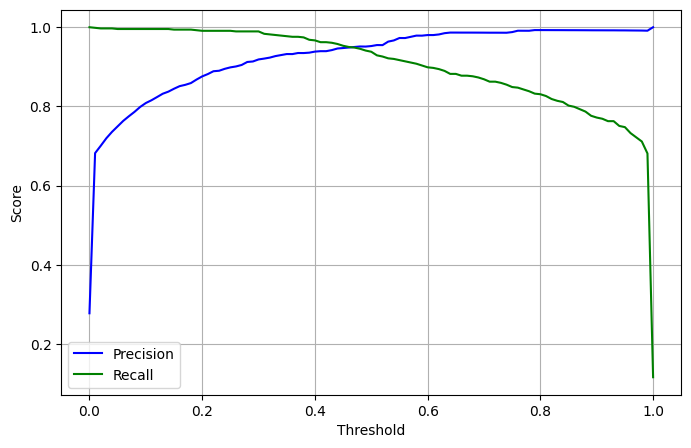

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0, 1.01, 0.01)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred = (model.predict_proba(X_val_scaled)[:, 1] >= threshold).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision_scores, label='Precision', color='b')
plt.plot(thresholds, recall_scores, label='Recall', color='g')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

intersection_threshold = thresholds[np.argmin(np.abs(np.array(precision_scores) - np.array(recall_scores)))]
print(round(intersection_threshold, 2))


## Question 4

In [27]:
from sklearn.metrics import f1_score

f1_scores = [f1_score(y_val, (model.predict_proba(X_val_scaled)[:, 1] >= threshold).astype(int)) for threshold in thresholds]
max_f1_score = max(f1_scores)
max_f1_threshold = thresholds[f1_scores.index(max_f1_score)]

print(round(max_f1_threshold, 2))


0.37


## Question 5

In [31]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores_cv = []

for train_idx, val_idx in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model_cv = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_cv.fit(X_train_fold, y_train_fold)
    
    auc_fold = roc_auc_score(y_val_fold, model_cv.predict_proba(X_val_fold)[:, 1])
    auc_scores_cv.append(auc_fold)

std_auc_cv = np.std(auc_scores_cv)
print(std_auc_cv)


0.000494167011885735


## Question 6

In [29]:
C_values = [0.01, 0.1, 0.5, 10]
mean_scores = []
std_scores = []

for C_value in C_values:
    auc_scores_cv = []
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model_cv = LogisticRegression(solver='liblinear', C=C_value, max_iter=1000)
        model_cv.fit(X_train_fold, y_train_fold)

        auc_fold = roc_auc_score(y_val_fold, model_cv.predict_proba(X_val_fold)[:, 1])
        auc_scores_cv.append(auc_fold)

    mean_auc = np.mean(auc_scores_cv)
    std_auc = np.std(auc_scores_cv)
    mean_scores.append(mean_auc)
    std_scores.append(std_auc)

best_C_index = mean_scores.index(max(mean_scores))
best_C = C_values[best_C_index]
best_std = std_scores[best_C_index]

print(best_C)


10
